# Homework #2: classification
Data source: http://archive.ics.uci.edu/ml/datasets/Polish+companies+bankruptcy+data

In [95]:
from scipy.io import arff
import pandas as pd
import numpy as np

In [96]:
data = arff.loadarff('4year.arff')
df = pd.DataFrame(data[0])

In [97]:
df['bankruptcy'] = (df['class']==b'1')
df.drop(columns=['class'], inplace=True)
df.columns = ['X{0:02d}'.format(k) for k in range(1,65)] + ['bankruptcy']

In [98]:
df.describe()

,X01,X02,X03,X04,X05,X06,X07,X08,X09,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50,X51,X52,X53,X54,X55,X56,X57,X58,X59,X60,X61,X62,X63,X64
count,9791.000000,9791.000000,9791.000000,9749.000000,9.771000e+03,9791.000000,9791.000000,9773.000000,9792.000000,9791.000000,9791.000000,9749.000000,9771.000000,9791.000000,9.784000e+03,9773.000000,9773.000000,9791.000000,9771.000000,9771.000000,9634.000000,9791.000000,9771.000000,9581.000000,9791.000000,9773.000000,9.151000e+03,9561.000000,9791.000000,9771.000000,9771.000000,9696.000000,9749.000000,9773.000000,9791.000000,9791.000000,5350.000000,9791.000000,9771.000000,9749.000000,9605.000000,9771.000000,9.771000e+03,9.771000e+03,9179.000000,9749.000000,9719.000000,9791.000000,9771.000000,9773.000000,9791.000000,9716.000000,9561.000000,9561.000000,9.792000e+03,9771.000000,9791.000000,9776.000000,9791.000000,9178.000000,9760.000000,9.771000e+03,9749.000000,9561.000000
mean,0.043019,0.596404,0.130959,8.136600,6.465164e+01,-0.059273,0.059446,19.884016,1.882296,0.389040,0.075417,0.210989,0.398902,0.059460,3.017681e+03,0.617918,20.976033,0.064580,-0.019081,62.704589,1.218724,0.066203,-0.070364,0.247742,0.222839,0.451115,1.115883e+03,6.725180,3.946479,5.353531,0.041258,341.625124,8.445313,4.979157,0.058091,2.077261,70.659877,0.487190,-1.072578,3.064235,0.968902,-0.371479,7.356944e+02,6.729892e+02,5.458024,7.274189,112.989701,-0.002370,-0.517222,7.085001,0.469319,10.031638,6.114681,7.402928,7.686330e+03,-0.992263,0.035022,1.133287,0.856053,118.156064,25.194430,2.015157e+03,8.660813,35.949619
std,0.359321,4.587122,4.559074,290.647281,1.475939e+04,6.812754,0.533344,698.697015,17.674650,4.590299,0.528232,74.237274,37.974787,0.533344,1.022731e+05,78.494223,698.757245,0.736143,25.583613,377.204157,5.930840,0.504481,23.889882,8.268015,4.852418,74.037751,3.143938e+04,147.963574,0.865714,340.974268,25.585724,6145.604519,69.690183,58.480776,0.483463,17.341615,621.311292,4.578432,77.056762,87.916989,41.191681,14.174896,3.283705e+04,3.281128e+04,186.414617,290.619843,1993.125597,0.525467,15.737098,287.770829,4.554869,897.307846,90.190534,146.013868,7.605261e+04,77.007971,8.945365,8.038201,26.393305,3230.316692,1099.260821,1.171461e+05,60.838202,483.318623
min,-12.458000,0.000000,-445.910000,-0.045319,-3.794600e+05,-486.820000,-12.458000,-1.848200,-0.032371,-445.910000,-12.244000,-6331.800000,-1460.600000,-12.458000,-1.567500e+06,-6331.800000,0.000857,-12.458000,-1578.700000,0.000000,-1.146300,-12.244000,-1578.700000,-314.370000,-466.340000,-6331.800000,-2.590100e+05,-990.020000,-0.440090,-4940.000000,-1495.600000,0.000000,0.000000,-756.500000,-9.043100,-0.000014,-3.715000,-445.910000,-7522.000000,-8.833300,-1086.800000,-719.800000,-1.158700e+05,-1.158700e+05,-2834.900000,-6.639200,-3.630700,-13.815000,-837.860000,-0.045239,0.000000,0.000000,-1033.700000,-1033.700000,-7.132200e+05,-7522.100000,-597.420000,-30.892000,-284.380000,0.000000,-12.656000,-1.496500e+04,-0.024390,-0.000015
25%,0.001321,0.263145,0.020377,1.047000,-5.121700e+01,-0.000578,0.003004,0.428300,1.006675,0.294440,0.009457,0.007608,0.021204,0.003008,2.173550e+02,0.061874,1.448900,0.003008,0.001937,15.244500,0.920125,0.000000,0.000963,0.004049,0.135600,0.057772,0.000000e+00,0.035097,3.398450,0.082730,0.004434,47.222750,2.702300,0.297400,0.000872,1.030900,1.097050,0.419750,0.000687,0.051234,0.025029,0.000000,6.890100e+01,3.651950e+01,0.010131,0.613890,15.836000,-0.047398,-0.035386,0.768760,0.185285,0.128978,0.684900,0.946990,2.184000e+01,0.003121,0.008768,0.885722,0.000000,5.356325,4.267700,4.323400e+01,2.938800,2.012900
50%,0.041364,0.467740,0.199290,1.591800,-5.557600e-02,0.000000,0.048820,1.088700,1.161300,0.510450,0.062544,0.143690,0.063829,0.048859,9.065550e+02,0.219130,2.134600,0.048859,0.030967,35.657000,1.045700,0.050118,0.025931,0.149150,0.386750,0.199240,1.005500e+00,0.470770,3.976400,0.226950,0.037939,80.884500,4.467

In [99]:
sum(df.bankruptcy == True)

515

In [100]:
df.fillna(df.mean(), inplace=True)
df.isna().sum()
X_imp = df.values
X_ori, y_ori = X_imp[:, :-1], X_imp[:, -1]
y_ori = y_ori.astype(bool)

### Unbalanced dataset
The dataset is unbalanced, and need over-sampling or under-sampling

In [101]:
print("number of samples:{},\n% bankruptcy: {:.2%}".format(df.shape[0], sum(df.bankruptcy == True) / df.shape[0]))

number of samples:9792,
% bankruptcy: 5.26%


Let's try under-sampling

In [102]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=0)
X, y = rus.fit_resample(X_ori, y_ori)
print("number of samples:{},\n% bankruptcy: {:.2%}".format(len(y), sum(y) / len(y)))

number of samples:1030,
% bankruptcy: 50.00%


In [103]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test =\
    train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

In [104]:
import sklearn.preprocessing as skpre

stdsc = skpre.StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
print(X_train_std.shape)
X_test_std = stdsc.transform(X_test)
print(X_test_std.shape)

(721, 64)
(309, 64)


## Find the 2 most important features
using Logistic Regression with L1 penalty

In [105]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import l1_min_c
from tqdm import tqdm
import time
# and put more...

### (1) Variable selection using L1 penalty
Select the 2 most important features using LogisticRegression with L1 penalty. (Adjust C until you see 2 features)

In [106]:
lr = LogisticRegression(
    penalty='l1',
    solver='liblinear',
    multi_class="ovr",
    tol=1e-4, 
    max_iter=int(1e2)
) # complete

C_span = l1_min_c(X_train_std, y_train, loss='log') * np.logspace(0, 4, 16)
C_span

array([1.07911519e-02, 1.99404279e-02, 3.68469157e-02, 6.80875657e-02,
       1.25815594e-01, 2.32488321e-01, 4.29603496e-01, 7.93842733e-01,
       1.46690213e+00, 2.71061481e+00, 5.00880903e+00, 9.25552675e+00,
       1.71028232e+01, 3.16034484e+01, 5.83984258e+01, 1.07911519e+02])

In [107]:
print("Computing regularization path ...")
coefs_ = []
C_span_t = tqdm(C_span)
tol_C = 1e-4
count_variables = 2
for c in C_span_t:
    C_span_t.set_description("C: {}".format(c))
    lr.set_params(C=c)
    lr.fit(X_train_std, y_train)
    coefs_.append(lr.coef_.copy())
    if (lr.coef_ != 0).sum() >= count_variables:
        break

C_left = C_span[len(coefs_) - 2]
C_right = C_span[len(coefs_) - 1]
coef_left = coefs_[-2]
coef_right = coefs_[-1]

while (coef_right != 0).sum() != count_variables or C_right - C_left > tol_C:
    C_try = np.sqrt(C_left * C_right)
    lr.set_params(C=C_try)
    lr.fit(X_train_std, y_train)
    coef_try = lr.coef_.copy()
    if (coef_try != 0).sum() >= count_variables:
        C_right = C_try
        coef_right = coef_try
    else:
        C_left = C_try
        coef_left = coef_try


C: 0.010791151930098742:   0%|          | 0/16 [00:00<?, ?it/s]D:\mine\app\python\python39\lib\site-packages\sklearn\svm\_base.py:974: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C: 0.019940427907986124:   6%|▋         | 1/16 [00:00<00:01, 11.76it/s]

Computing regularization path ...


In [108]:
lr.set_params(C=C_right)
lr.fit(X_train_std, y_train)
print("C: {},\ncoef: {}".format(C_right, coef_right))

C: 0.011294304015967092,
coef: [[ 0.          0.          0.          0.          0.          0.
  -0.0004113   0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.         -0.02262636  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]]


In [109]:
lr.coef_[lr.coef_!=0].shape # check the number of the features with non-zero weights

(2,)

In [110]:
# redefine X_train_std and X_test_std
X_train_std = X_train_std[:, lr.coef_[0]!=0]
X_test_std = X_test_std[:, lr.coef_[0]!=0]

## Apply LR / SVM / Decision Tree below
Using the 2 selected features, apply LR / SVM / decision tree. Try your own hyperparameters (C, gamma, tree depth, etc) to maximize the prediction accuracy. (Just try several values. You don't need to show your answer is the maximum.)

In [111]:
from sklearn.model_selection import GridSearchCV

### (1) LR with L1 penalty
hyper-parameter: C

In [112]:
print("## LR with L1 penalty, C={}".format(C_right))
lr1 = LogisticRegression(
    penalty='l1', 
    C=C_right,
    solver='liblinear', 
    multi_class="ovr"
)
lr1.fit(X_train_std, y_train)
print('Training accuracy:', lr1.score(X_train_std, y_train))
print('Test accuracy:', lr1.score(X_test_std, y_test))

CV_lr1 = GridSearchCV(
    lr1, 
    param_grid={
        'C': np.logspace(-4,4,100) * C_right
    }, 
    cv=3, 
    scoring='accuracy',
    verbose=0
)
CV_lr1.fit(X_train_std, y_train)
C_best_lr1 = CV_lr1.best_params_["C"]
lr1 = CV_lr1.best_estimator_
print("## LR with L1 penalty, C={}".format(C_best_lr1))
print('Training accuracy:', CV_lr1.best_score_)
print('Test accuracy:', lr1.score(X_test_std, y_test))

## LR with L1 penalty, C=0.011294304015967092
Training accuracy: 0.6768377253814147
Test accuracy: 0.6537216828478964
## LR with L1 penalty, C=0.24332840371765957
Training accuracy: 0.6782042415859842
Test accuracy: 0.6407766990291263


### (2) LR with L2 penalty
hyper-parameter: C

In [113]:
print("## LR with L2 penalty, C={}".format(1))
lr2 = LogisticRegression(
    penalty='l2', 
    C=1,
    solver='lbfgs', 
    multi_class="ovr"
)
lr2.fit(X_train_std, y_train)
print('Training accuracy:', lr2.score(X_train_std, y_train))
print('Test accuracy:', lr2.score(X_test_std, y_test))

CV_lr2 = GridSearchCV(
    lr2, 
    param_grid={
        'C': np.logspace(-4,4,100) * 1
    }, 
    cv=3, 
    scoring='accuracy',
    verbose=0
)
CV_lr2.fit(X_train_std, y_train)
C_best_lr2 = CV_lr2.best_params_["C"]
lr2 = CV_lr2.best_estimator_
print("## LR with L2 penalty, C={}".format(C_best_lr2))
print('Training accuracy:', CV_lr2.best_score_)
print('Test accuracy:', lr2.score(X_test_std, y_test))

## LR with L2 penalty, C=1
Training accuracy: 0.6726768377253814
Test accuracy: 0.6310679611650486
## LR with L2 penalty, C=0.00025353644939701115
Training accuracy: 0.6823766712770863
Test accuracy: 0.6245954692556634


### (3) SVM
hyper-parameter: C, gamma

In [114]:
print("## SVM, C={}, gamma={}".format(1, 0.5))
svm = SVC(
    kernel='rbf', 
    C=1.0, 
    gamma=0.5,
    random_state=1,
    tol=1e-2
#     max_iter=1000
)
svm.fit(X_train_std, y_train)
print('Training accuracy:', svm.score(X_train_std, y_train))
print('Test accuracy:', svm.score(X_test_std, y_test))

CV_svm = GridSearchCV(
    svm, 
    param_grid={
        'C': np.logspace(-2,2,4) * 1,
        'gamma': np.logspace(-2,2,4) * 0.5,
    }, 
    cv=3, 
    scoring='accuracy',
    verbose=0
)
CV_svm.fit(X_train_std, y_train)
C_best_svm = CV_svm.best_params_["C"]
gamma_best_svm = CV_svm.best_params_["gamma"]
svm = CV_svm.best_estimator_
print("## SVM, C={}, gamma={}".format(C_best_svm, gamma_best_svm))
print('Training accuracy:', CV_svm.best_score_)
print('Test accuracy:', svm.score(X_test_std, y_test))

## SVM, C=1, gamma=0.5
Training accuracy: 0.6712898751733704
Test accuracy: 0.6472491909385113
## SVM, C=4.6415888336127775, gamma=50.0
Training accuracy: 0.680982019363762
Test accuracy: 0.6537216828478964


### (4) Decision Tree
hyper-parameter: C

In [115]:
print("## Decision Tree, criterion={}, max_depth={}".format('gini', 4))
tree_model = DecisionTreeClassifier(
    criterion='gini', 
    max_depth=4,
    random_state=1
)
tree_model.fit(X_train_std, y_train)
print('Training accuracy:', tree_model.score(X_train_std, y_train))
print('Test accuracy:', tree_model.score(X_test_std, y_test))

CV_tree_model = GridSearchCV(
    tree_model, 
    param_grid={
        'criterion': ["gini", "entropy"],
        'max_depth': range(1, 10),
    }, 
    cv=3, 
    scoring='accuracy',
    verbose=0
)
CV_tree_model.fit(X_train_std, y_train)
C_best_criterion = CV_tree_model.best_params_["criterion"]
C_best_max_depth = CV_tree_model.best_params_["max_depth"]
tree_model = CV_tree_model.best_estimator_
print("## Decision Tree, criterion={}, max_depth={}".format(C_best_criterion, C_best_max_depth))
print('Training accuracy:', CV_tree_model.best_score_)
print('Test accuracy:', tree_model.score(X_test_std, y_test))

## Decision Tree, criterion=gini, max_depth=4
Training accuracy: 0.7281553398058253
Test accuracy: 0.6634304207119741
## Decision Tree, criterion=gini, max_depth=2
Training accuracy: 0.6754495159059474
Test accuracy: 0.6375404530744336


## Visualize the classification

In [127]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02, ax=None):

    if ax is None:
        ax = plt.gca()
    # setup marker generator and color map
    markers = ('s', 'D', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    ax.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    ax.set_xlim(xx1.min(), xx1.max())
    ax.set_ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        ax.scatter(
            x=X[y == cl, 0], 
            y=X[y == cl, 1],
            alpha=0.8, 
            c=colors[idx],
            marker=markers[idx], 
            label=cl, 
            edgecolor='black'
        )

    # highlight test samples
    if test_idx:
        # plot all samples
        X_test, y_test = X[test_idx, :], y[test_idx]

        ax.scatter(
            X_test[:, 0],
            X_test[:, 1],
            c="none",
            edgecolor='black',
            alpha=1,
            linewidth=1,
            marker='o',
            s=100, 
            label='test set'
        )
        
    ax.legend(loc='upper left')

Z:\Temp/ipykernel_28688/4223542355.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


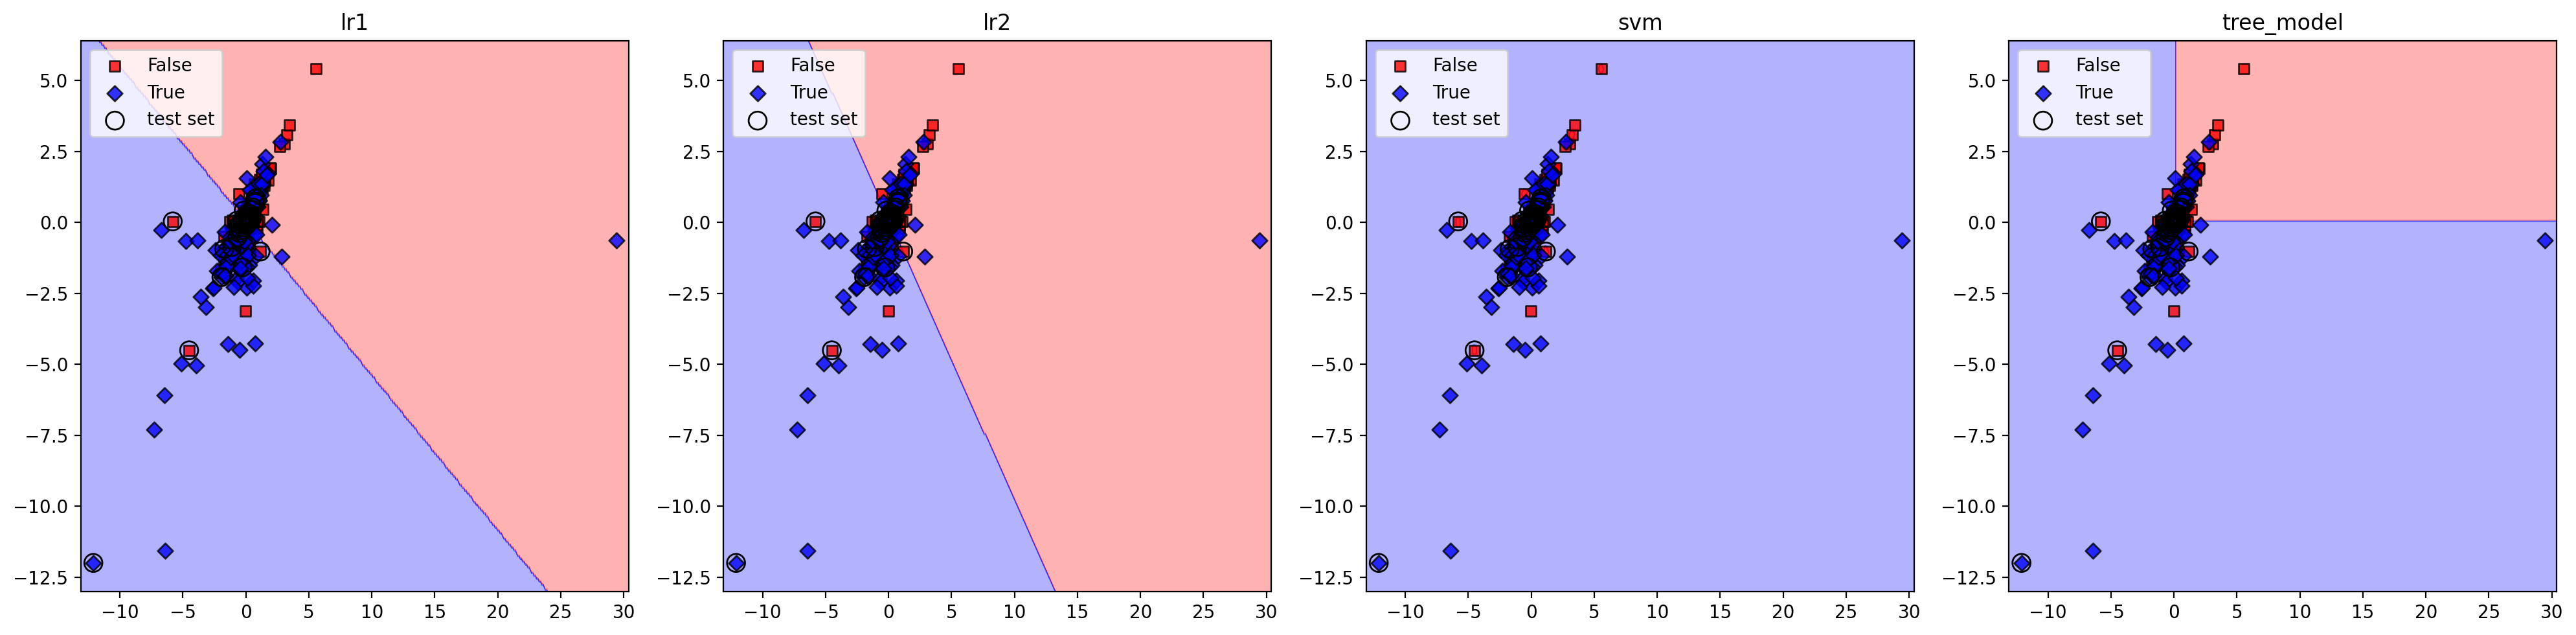

In [129]:
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))
model_names = ["lr1", "lr2", "svm", "tree_model"]

fig, axs = plt.subplots(1, 4, figsize=(20, 5))

for clf, ax in zip(model_names, axs):
    plot_decision_regions(
        X=X_combined_std, 
        y=y_combined,
        classifier=eval(clf), 
        test_idx=range(0, 50),
        resolution=0.1,
        ax=ax
    )
    ax.set_title(clf)


fig.tight_layout()
fig.savefig('test_result.png', dpi=300, bbox_inches="tight")
fig.show()